## 1. EDA

### Importing Packages and loading datasets

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
# import missingno as msno
from scipy.stats import zscore # Z-score method for outlier detection
from statsmodels.stats.outliers_influence import variance_inflation_factor

train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')
cleaned_train = pd.read_csv('./train_without_outliers.csv')

### Generates statistical summaries

In [ ]:
# Train Info
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 360336 entries, 0 to 360335
Data columns (total 17 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   id                          360336 non-null  int64  
 1   store_sales(in millions)    360336 non-null  float64
 2   unit_sales(in millions)     360336 non-null  float64
 3   total_children              360336 non-null  float64
 4   num_children_at_home        360336 non-null  float64
 5   avg_cars_at home(approx).1  360336 non-null  float64
 6   gross_weight                360336 non-null  float64
 7   recyclable_package          360336 non-null  float64
 8   low_fat                     360336 non-null  float64
 9   units_per_case              360336 non-null  float64
 10  store_sqft                  360336 non-null  float64
 11  coffee_bar                  360336 non-null  float64
 12  video_store                 360336 non-null  float64
 13  salad_bar     

In [ ]:
# Test Info
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240224 entries, 0 to 240223
Data columns (total 16 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   id                          240224 non-null  int64  
 1   store_sales(in millions)    240224 non-null  float64
 2   unit_sales(in millions)     240224 non-null  float64
 3   total_children              240224 non-null  float64
 4   num_children_at_home        240224 non-null  float64
 5   avg_cars_at home(approx).1  240224 non-null  float64
 6   gross_weight                240224 non-null  float64
 7   recyclable_package          240224 non-null  float64
 8   low_fat                     240224 non-null  float64
 9   units_per_case              240224 non-null  float64
 10  store_sqft                  240224 non-null  float64
 11  coffee_bar                  240224 non-null  float64
 12  video_store                 240224 non-null  float64
 13  salad_bar     

### Splitting columns into Numerical and Categorical

In [ ]:
numerical_cols = []
binary_cols = []

for col in train.columns:
    if len(train[col].unique()) == 2:
        binary_cols.append(col)
    else:
        if col == 'id' or col == 'cost':
            continue
        else:
            numerical_cols.append(col)

In [ ]:
target = train['cost']

### Check for missing values, duplicate roles

In [ ]:
def summary(df):
    print(f"\n📊 Data Shape: {df.shape}\n")
    
    #Identifying Data Types and Unique Values
    summ = pd.DataFrame(df.dtypes, columns=["Data Type"])    
    
    #check for missing values
    summ["# Missing"] = df.isnull().sum()
    summ["% Missing"] = (df.isnull().sum() / len(df)) * 100

    missing_data = pd.DataFrame({'Missing Values': summ["# Missing"], 'Percentage': summ["% Missing"]})
    # print(missing_data[missing_data['Missing Values'] > 0])
    print(f'There are {df.isna().sum().sum()} null values')


    #check unique values
    summ["# Unique"] = df.nunique()
    
    desc = df.describe(include="all").transpose()
    summ["Min"] = desc.get("min")
    summ["Max"] = desc.get("max")
    
    # Add first three values if enough rows exist
    for i in range(3):
        if len(df) > i:
            summ[f"Value {i+1}"] = df.iloc[i]
    
    # Formatting for better readability
    return summ.style.format({
        "% Missing": "{:.2f}%",
        "Min": "{:.2f}",
        "Max": "{:.2f}"
    }).bar(subset=["% Missing"], color="lightcoral")  # Highlight missing data

In [ ]:
# Display summary of the training data
summary(train)


📊 Data Shape: (360336, 17)

There are 0 null values


C:\Users\other\anaconda3\Lib\site-packages\pandas\io\formats\style.py:4052: RuntimeWarning: invalid value encountered in scalar divide
  end = (x - left) / (right - left)


,Data Type,# Missing,% Missing,# Unique,Min,Max,Value 1,Value 2,Value 3
id,int64,0,0.00%,360336,0.00,360335.00,0.000000,1.000000,2.000000
store_sales(in millions),float64,0,0.00%,1044,0.51,22.92,8.610000,5.000000,14.080000
unit_sales(in millions),float64,0,0.00%,6,1.00,6.00,3.000000,2.000000,4.000000
total_children,float64,0,0.00%,6,0.00,5.00,2.000000,4.000000,0.000000
num_children_at_home,float64,0,0.00%,6,0.00,5.00,2.000000,0.000000,0.000000
avg_cars_at home(approx).1,float64,0,0.00%,5,0.00,4.00,2.000000,3.000000,3.000000
gross_weight,float64,0,0.00%,384,6.00,21.90,10.300000,6.660000,21.300000
recyclable_package,float64,0,0.00%,2,0.00,1.00,1.000000,1.000000,1.000000
low_fat,float64,0,0.00%,2,0.00,1.00,0.000000,0.000000,0.000000
units_per_case,float64,0,0.00%,36,1.00,36.00,32.000000,1.000000,26.000000


In [ ]:
# Display summary of the test data
summary(test)


📊 Data Shape: (240224, 16)

There are 0 null values


C:\Users\other\anaconda3\Lib\site-packages\pandas\io\formats\style.py:4052: RuntimeWarning: invalid value encountered in scalar divide
  end = (x - left) / (right - left)


,Data Type,# Missing,% Missing,# Unique,Min,Max,Value 1,Value 2,Value 3
id,int64,0,0.00%,240224,360336.00,600559.00,360336.000000,360337.000000,360338.000000
store_sales(in millions),float64,0,0.00%,1035,0.51,22.92,7.240000,6.900000,8.340000
unit_sales(in millions),float64,0,0.00%,6,1.00,6.00,4.000000,2.000000,3.000000
total_children,float64,0,0.00%,6,0.00,5.00,1.000000,2.000000,0.000000
num_children_at_home,float64,0,0.00%,6,0.00,5.00,0.000000,2.000000,0.000000
avg_cars_at home(approx).1,float64,0,0.00%,5,0.00,4.00,2.000000,3.000000,3.000000
gross_weight,float64,0,0.00%,380,6.00,21.90,10.800000,8.510000,8.770000
recyclable_package,float64,0,0.00%,2,0.00,1.00,0.000000,1.000000,0.000000
low_fat,float64,0,0.00%,2,0.00,1.00,1.000000,0.000000,1.000000
units_per_case,float64,0,0.00%,36,1.00,36.00,7.000000,4.000000,14.000000


### Checking for duplicate rows

In [ ]:
duplicates = train.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")

# If necessary, remove duplicates
train = train.drop_duplicates()


Number of duplicate rows: 0


### Checking for Anomalies

In [ ]:
# Descriptions for Numerical Columns
train[numerical_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
store_sales(in millions),360336.0,6.337376,3.307980,0.51,3.72,5.78,8.4,22.92
unit_sales(in millions),360336.0,3.043881,0.784676,1.00,3.00,3.00,4.0,6.00
total_children,360336.0,2.456482,1.488992,0.00,1.00,2.00,4.0,5.00
num_children_at_home,360336.0,0.689390,1.214732,0.00,0.00,0.00,1.0,5.00
avg_cars_at home(approx).1,360336.0,2.203813,1.084293,0.00,1.00,2.00,3.0,4.00
gross_weight,360336.0,13.822071,4.614792,6.00,9.71,13.60,17.7,21.90
units_per_case,360336.0,18.972706,10.212912,1.00,10.00,20.00,28.0,36.00
store_sqft,360336.0,28180.333442,5968.874074,20319.00,23593.00,27694.00,33858.0,39696.00


In [ ]:
# Descriptions for Binary Columns
train[binary_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
recyclable_package,360336.0,0.568086,0.495343,0.0,0.0,1.0,1.0,1.0
low_fat,360336.0,0.327797,0.469411,0.0,0.0,0.0,1.0,1.0
coffee_bar,360336.0,0.564839,0.495779,0.0,0.0,1.0,1.0,1.0
video_store,360336.0,0.277394,0.447713,0.0,0.0,0.0,1.0,1.0
salad_bar,360336.0,0.504807,0.499978,0.0,0.0,1.0,1.0,1.0
prepared_food,360336.0,0.504832,0.499977,0.0,0.0,1.0,1.0,1.0
florist,360336.0,0.503191,0.499991,0.0,0.0,1.0,1.0,1.0


### Checking for Outliers

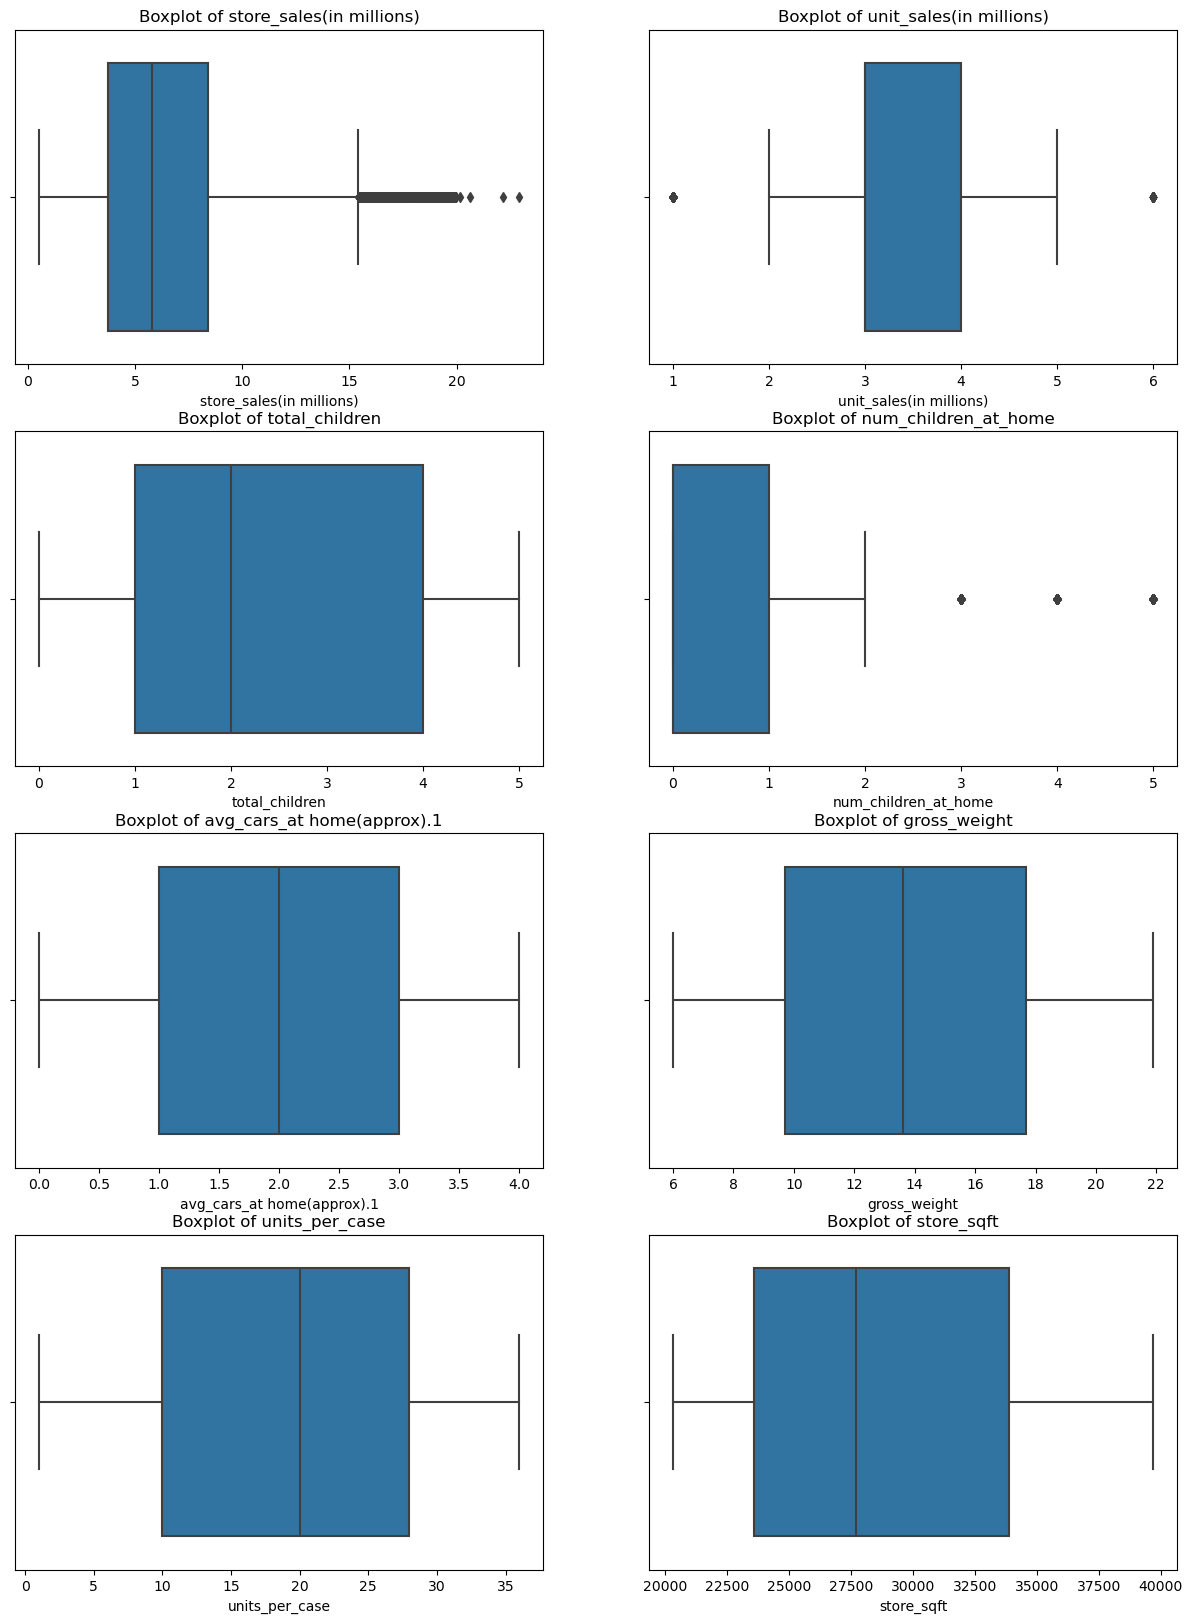

Number of outliers detected: 7083


In [ ]:
num_cols = len(numerical_cols)
ncols = 2
nrows = math.ceil(num_cols / ncols)  # Calculate the number of rows

# Create subplots
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 5 * nrows))
# Ensure axes is always a flat list
if num_cols == 1:
    axes = [axes]  # Convert single subplot into a list
else:
    axes = axes.flatten()  # Flatten 2D array into 1D list

# Boxplot for numerical variables
for i,col in enumerate(numerical_cols):
    # plt.figure(figsize=(8, 4))
    # sns.boxplot(x=train[col])
    # plt.title(f"Boxplot of {col}")
    # plt.show()
    sns.boxplot(x=train[col], ax=axes[i])
    axes[i].set_title(f"Boxplot of {col}")

# Hide unused subplots if num_cols is odd
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.show()


train_outliers = train[(train.select_dtypes(include=['number']).apply(zscore) > 3).any(axis=1)]
print(f"Number of outliers detected: {train_outliers.shape[0]}")


### Checking for Skewness

In [ ]:
train.skew()

id                           -1.413940e-15
store_sales(in millions)      6.614917e-01
unit_sales(in millions)      -1.079984e-01
total_children                3.513447e-02
num_children_at_home          1.848681e+00
avg_cars_at home(approx).1   -7.343603e-02
gross_weight                  9.330480e-02
recyclable_package           -2.749077e-01
low_fat                       7.337030e-01
units_per_case               -1.020089e-01
store_sqft                    3.926991e-01
coffee_bar                   -2.615677e-01
video_store                   9.944196e-01
salad_bar                    -1.922747e-02
prepared_food                -1.932739e-02
florist                      -1.276618e-02
cost                          1.913221e-02
dtype: float64

In [ ]:
features = train.columns.tolist()
print(features)

['id', 'store_sales(in millions)', 'unit_sales(in millions)', 'total_children', 'num_children_at_home', 'avg_cars_at home(approx).1', 'gross_weight', 'recyclable_package', 'low_fat', 'units_per_case', 'store_sqft', 'coffee_bar', 'video_store', 'salad_bar', 'prepared_food', 'florist', 'cost']


In [ ]:
# Features
features = ['store_sales(in millions)', 'unit_sales(in millions)', 'total_children',
            'num_children_at_home', 'avg_cars_at home(approx).1',
            'gross_weight', 'recyclable_package', 'low_fat', 'units_per_case', 'store_sqft', 'coffee_bar',
            'video_store', 'salad_bar', 'prepared_food', 'florist']

### Correlation Matrix to check for Multicolinearity

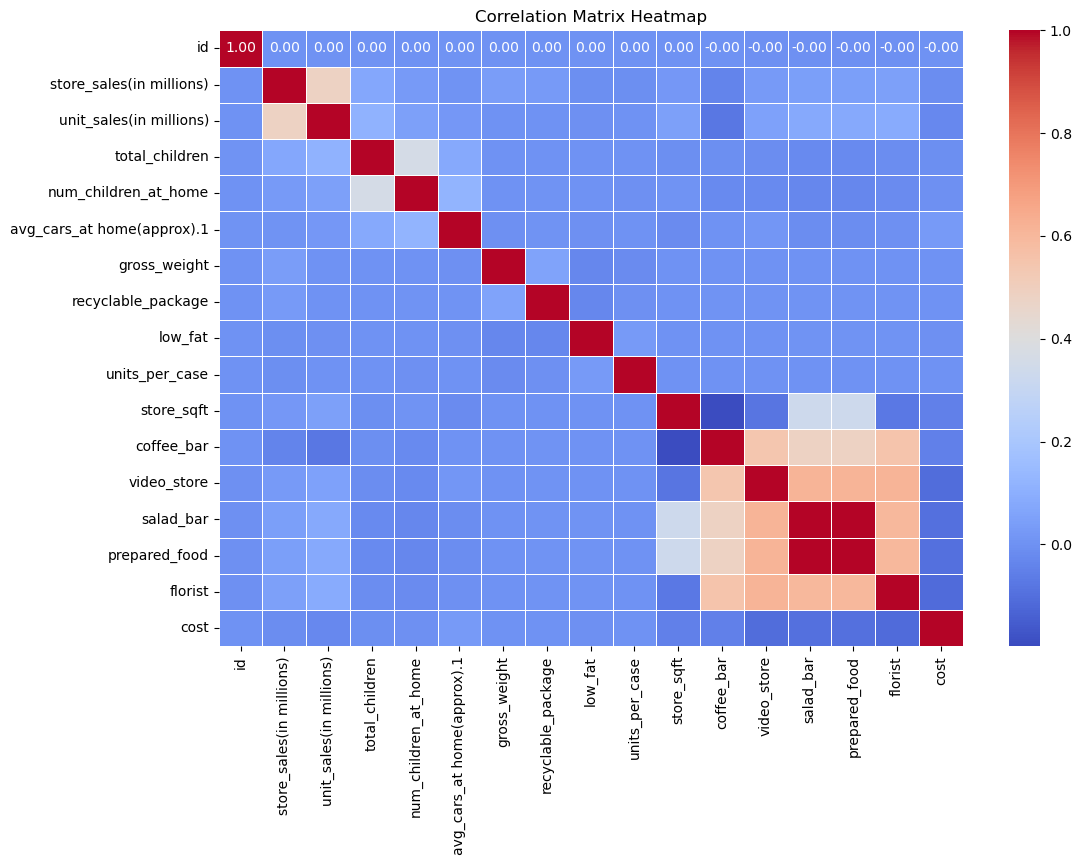

                       Feature          VIF
0                        const    89.287940
1                           id     1.000040
2     store_sales(in millions)     1.306207
3      unit_sales(in millions)     1.349369
4               total_children     1.164155
5         num_children_at_home     1.159701
6   avg_cars_at home(approx).1     1.017042
7                 gross_weight     1.006506
8           recyclable_package     1.005368
9                      low_fat     1.002895
10              units_per_case     1.001342
11                  store_sqft     1.548277
12                  coffee_bar     1.820315
13                 video_store     2.131015
14                   salad_bar  3106.902709
15               prepared_food  3106.955374
16                     florist     2.077165
17                        cost     1.019920
Features with high VIF: ['const', 'salad_bar', 'prepared_food']
Highly correlated features: {'prepared_food'}
Features to drop: {'const', 'prepared_food', 'salad_ba

In [ ]:
# Step 1: Calculate correlation matrix
corr_matrix = train[features].corr()

# Plot correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

# Step 2: Calculate VIF for each feature
# Add constant to the data (for VIF calculation)
X = train[features]
X_with_const = add_constant(X)  # Adds a constant column for VIF calculation

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["Feature"] = X_with_const.columns
vif_data["VIF"] = [variance_inflation_factor(X_with_const.values, i) for i in range(X_with_const.shape[1])]

# Display VIF data
print(vif_data)

# Step 3: Feature selection based on VIF and correlation
# Thresholds for VIF and correlation
VIF_THRESHOLD = 10  # Features with VIF above 10 are considered to have high multicollinearity
CORR_THRESHOLD = 0.8  # Correlation greater than 0.8 means features are highly correlated

# Remove features with high VIF
high_vif_features = vif_data[vif_data['VIF'] > VIF_THRESHOLD]['Feature'].tolist()
print(f"Features with high VIF: {high_vif_features}")

# Remove features with high correlation
correlated_features = []
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > CORR_THRESHOLD:
            colname = corr_matrix.columns[i]
            correlated_features.append(colname)

print(f"Highly correlated features: {set(correlated_features)}")

# Combine features to drop: high VIF and high correlation
features_to_drop = set(high_vif_features + correlated_features)
print(f"Features to drop: {features_to_drop}")

# Final feature set after dropping highly correlated and high-VIF features
final_features = [f for f in features if f not in features_to_drop]
print(f"Selected features: {final_features}")

# Now, we can continue with feature selection
X_train_selected = train[final_features]

Nothing is highly correlated with each other, store_sales and unit_sales being correlated, total_children and num_children_at_home being correlated, as well as the binary categories being correlated with each other make sense. The degree of correlation is not high enough to be concerning.

In [ ]:
# Cleaning data by removing outliers
# Outlier detection using IQR method
def remove_outliers(df, features):
    # Calculate the IQR for each feature
    for feature in features:
        Q1 = df[feature].quantile(0.25)
        Q3 = df[feature].quantile(0.75)
        IQR = Q3 - Q1
        
        # Define bounds for detecting outliers
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Remove outliers
        df = df[(df[feature] >= lower_bound) & (df[feature] <= upper_bound)]
    return df

In [ ]:
# Remove outliers
train_cleaned = remove_outliers(train.copy(), features)

In [ ]:
train.shape, train_cleaned.shape

((360336, 17), (312253, 17))

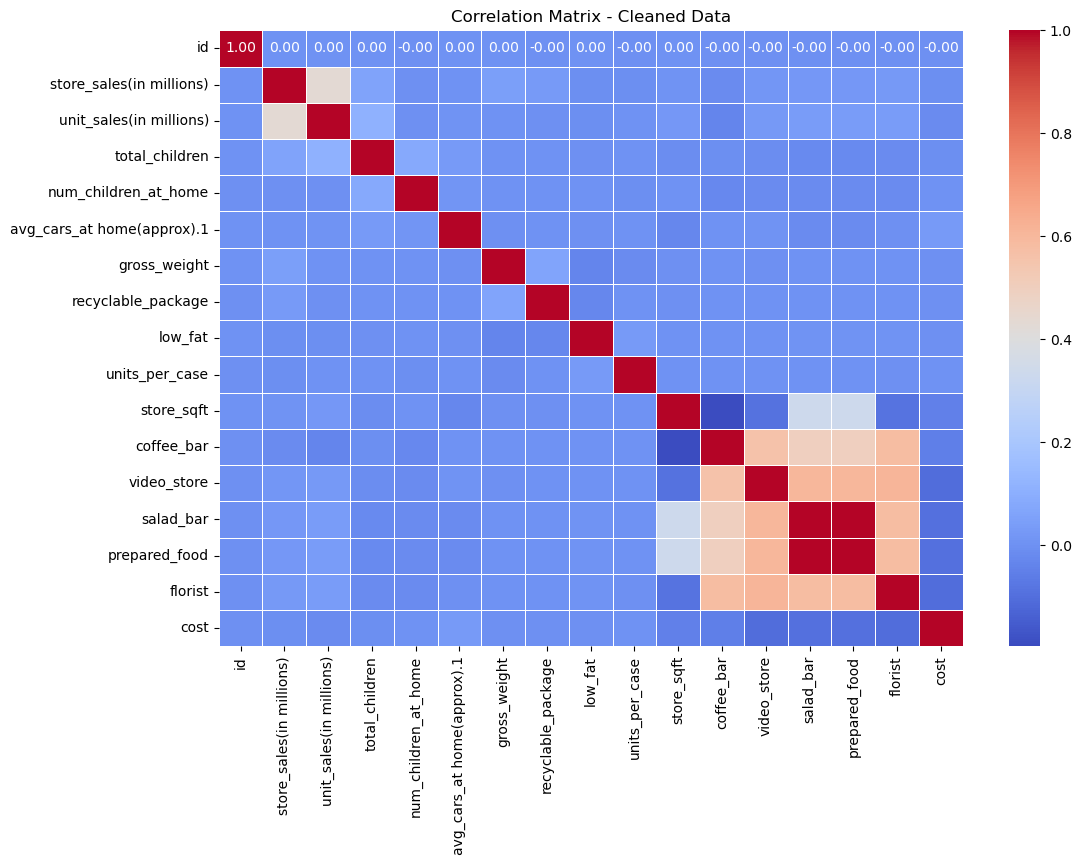

                       Feature          VIF
0                        const    90.769014
1                           id     1.000040
2     store_sales(in millions)     1.233793
3      unit_sales(in millions)     1.247835
4               total_children     1.020810
5         num_children_at_home     1.007908
6   avg_cars_at home(approx).1     1.002976
7                 gross_weight     1.007173
8           recyclable_package     1.005540
9                      low_fat     1.002809
10              units_per_case     1.001318
11                  store_sqft     1.556000
12                  coffee_bar     1.876885
13                 video_store     2.120811
14                   salad_bar  3544.475164
15               prepared_food  3544.338435
16                     florist     2.053091
17                        cost     1.019128
Features with high VIF: ['const', 'salad_bar', 'prepared_food']
Highly correlated features: {'prepared_food'}
Features to drop: {'const', 'prepared_food', 'salad_ba

In [ ]:
# Dataset after removing outliers
# Step 1: Calculate correlation matrix
corr_matrix = train_cleaned[features].corr()

# Plot correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, cmap='coolwarm', fmt='.2f', linewidths=0.5, annot=True)
plt.title('Correlation Matrix - Cleaned Data')
plt.show()

# Step 2: Calculate VIF for each feature
# Add constant to the data (for VIF calculation)
X = train_cleaned[features]
X_with_const = add_constant(X)  # Adds a constant column for VIF calculation

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["Feature"] = X_with_const.columns
vif_data["VIF"] = [variance_inflation_factor(X_with_const.values, i) for i in range(X_with_const.shape[1])]

# Display VIF data
print(vif_data)

# Step 3: Feature selection based on VIF and correlation
# Thresholds for VIF and correlation
VIF_THRESHOLD = 10  # Features with VIF above 10 are considered to have high multicollinearity
CORR_THRESHOLD = 0.8  # Correlation greater than 0.8 means features are highly correlated

# Remove features with high VIF
high_vif_features = vif_data[vif_data['VIF'] > VIF_THRESHOLD]['Feature'].tolist()
print(f"Features with high VIF: {high_vif_features}")

# Remove features with high correlation
correlated_features = []
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > CORR_THRESHOLD:
            colname = corr_matrix.columns[i]
            correlated_features.append(colname)

print(f"Highly correlated features: {set(correlated_features)}")

# Combine features to drop: high VIF and high correlation
features_to_drop = set(high_vif_features + correlated_features)
print(f"Features to drop: {features_to_drop}")

# Final feature set after dropping highly correlated and high-VIF features
final_features = [f for f in features if f not in features_to_drop]
print(f"Selected features: {final_features}")

# Now, we can continue with feature selection
X_train_selected = train_cleaned[final_features]

### Pairplot for Relationship between Features

C:\Users\other\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\other\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\other\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\other\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

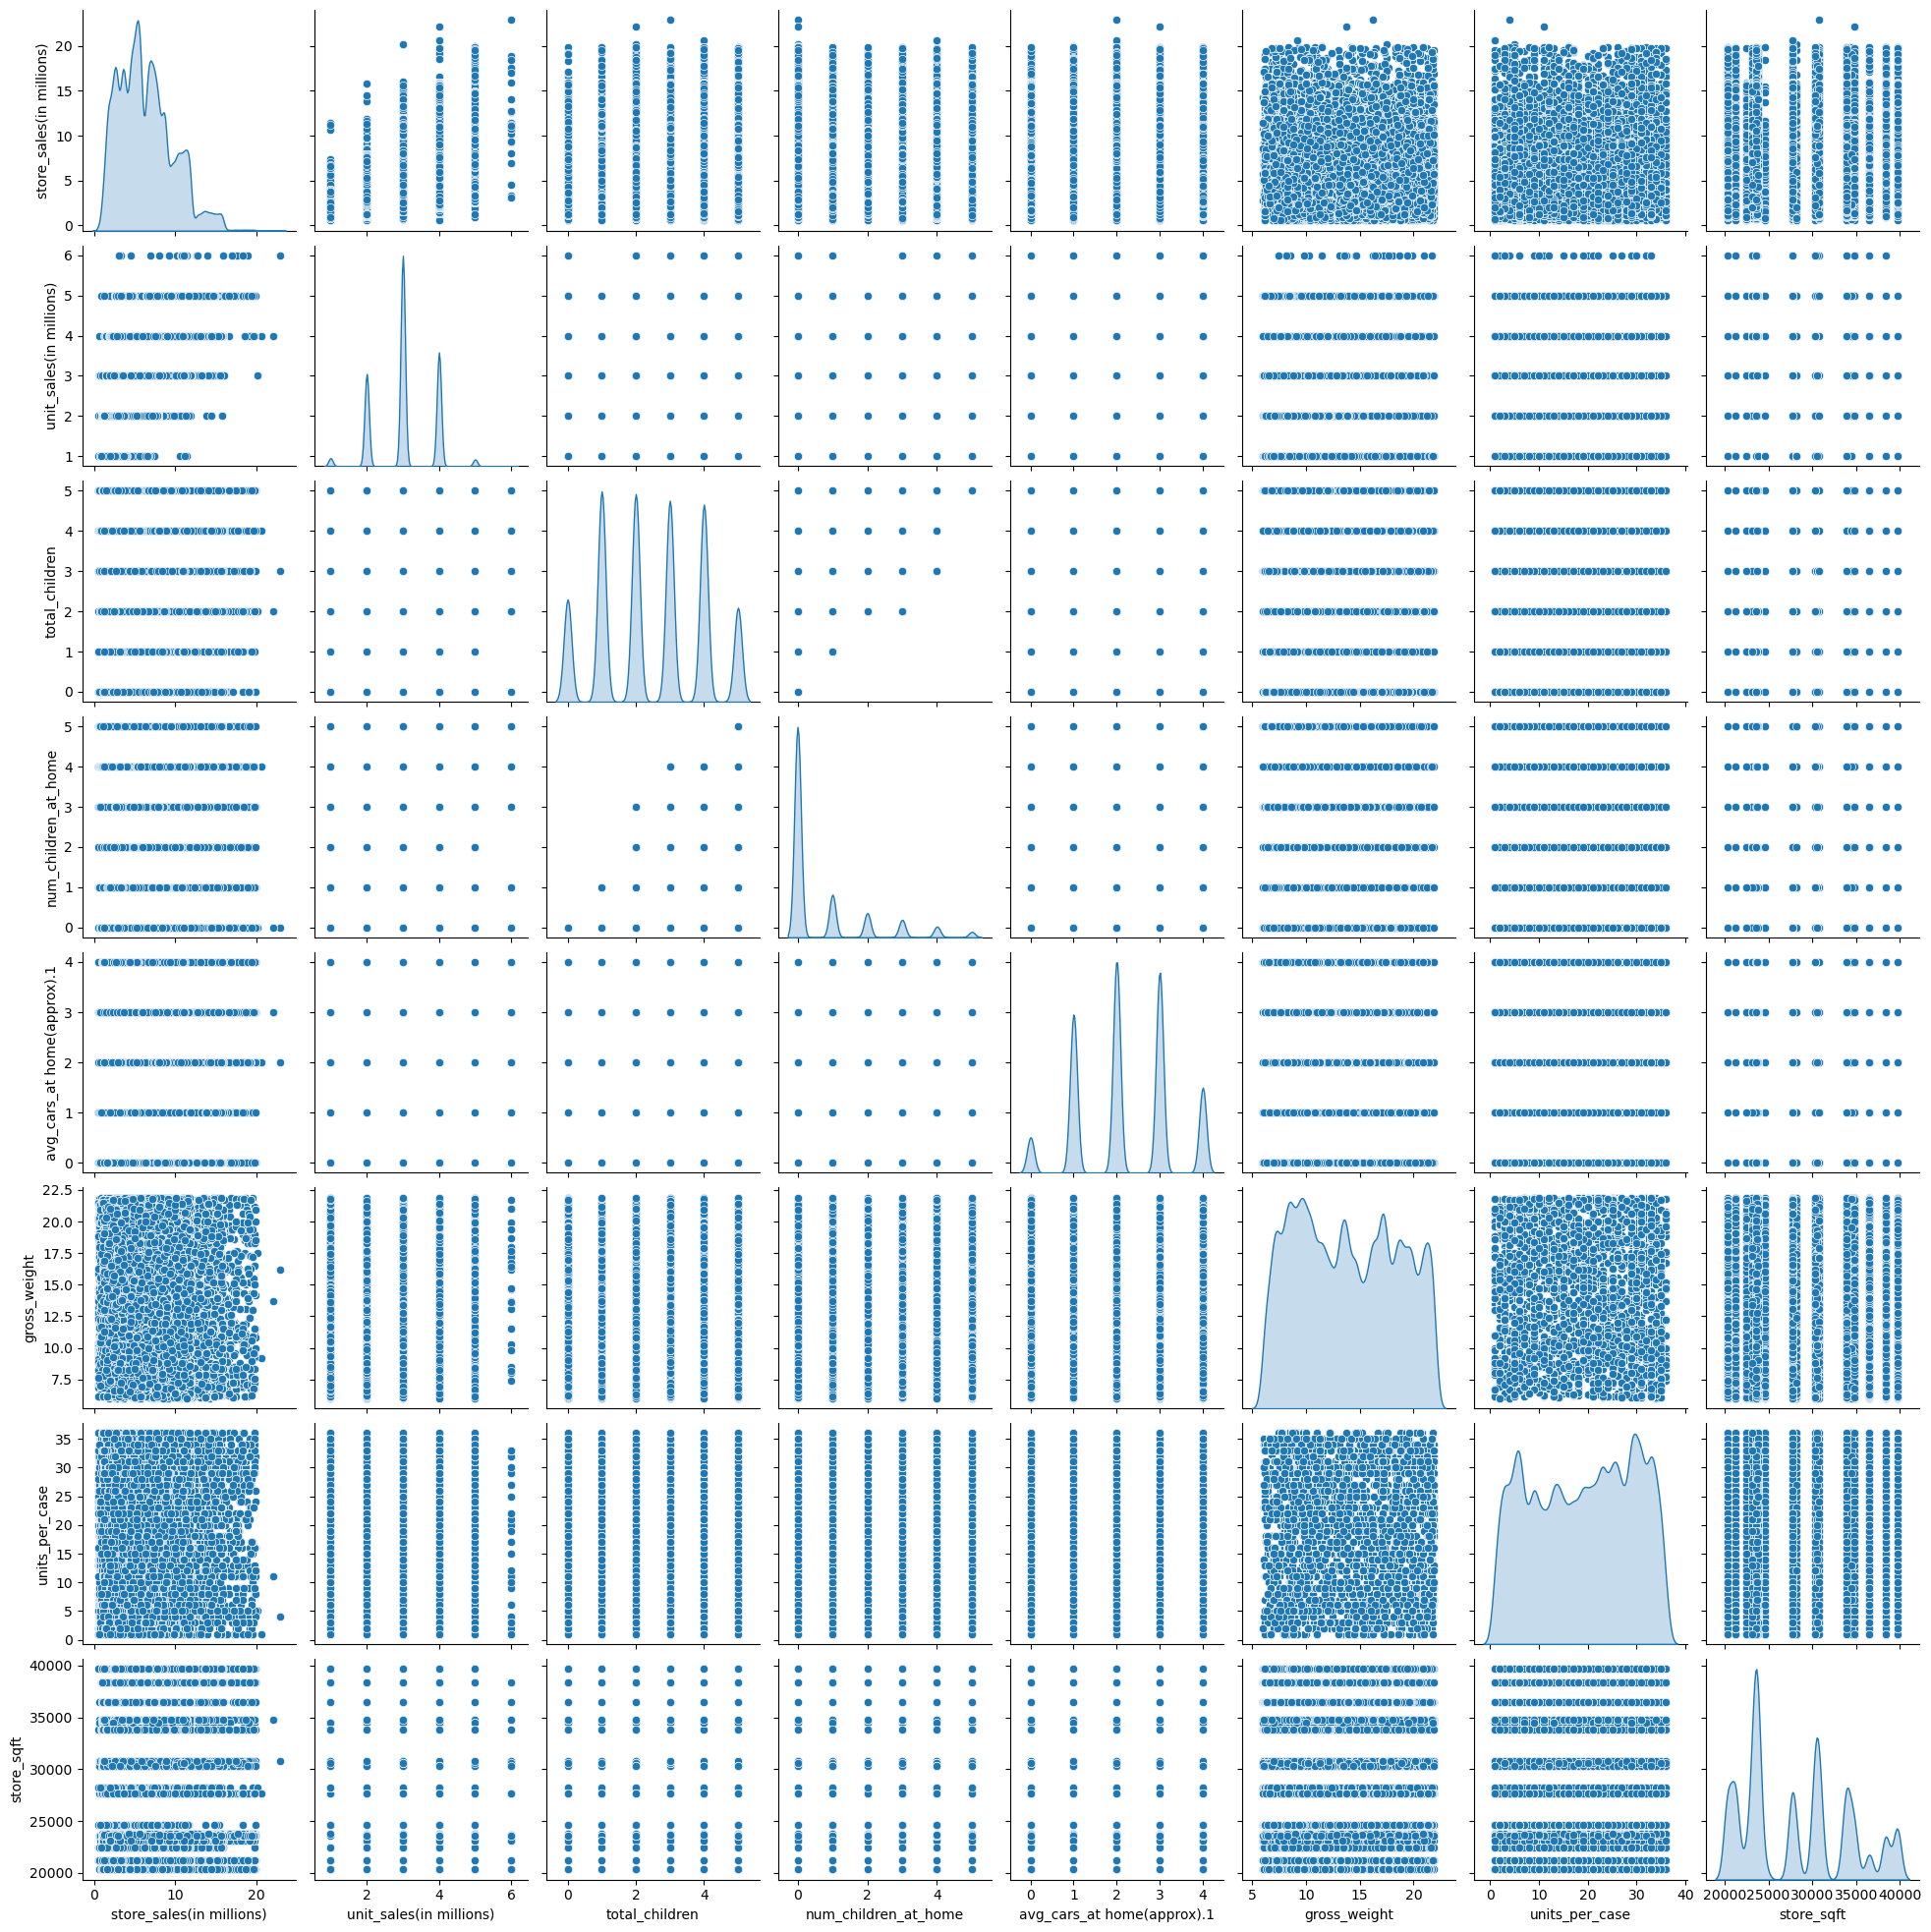

In [ ]:
sns.pairplot(train[numerical_cols], diag_kind="kde")
plt.show()

### Relationship between Numerical Columns and Target

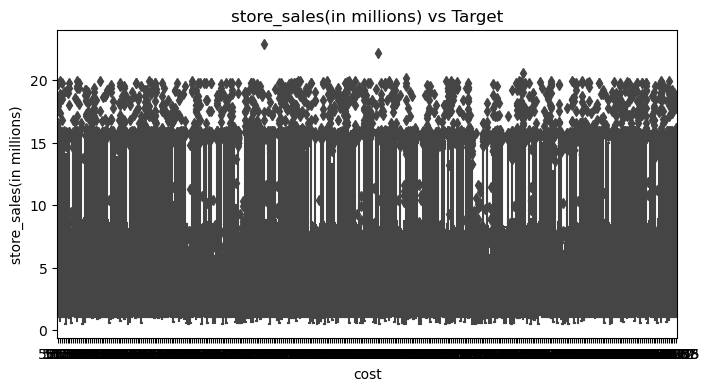

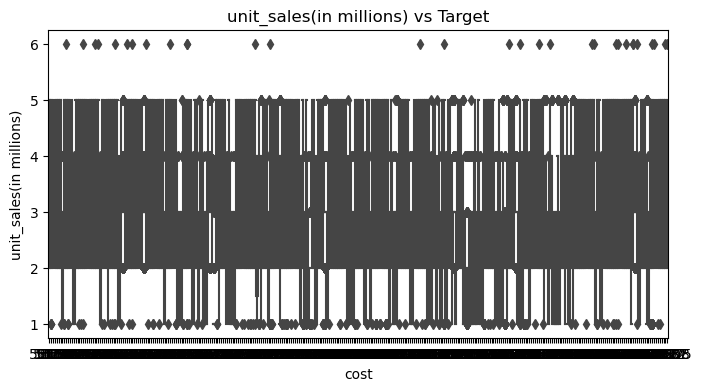

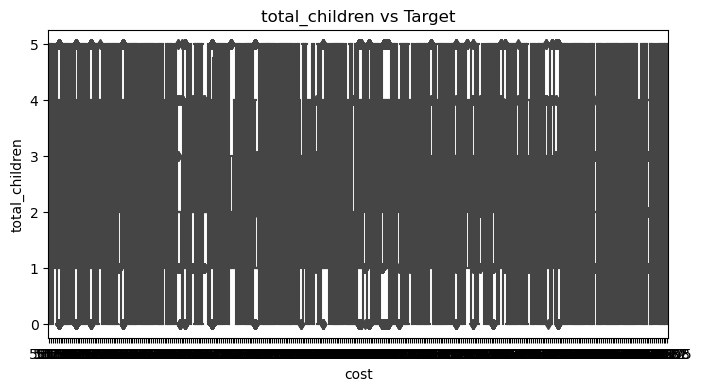

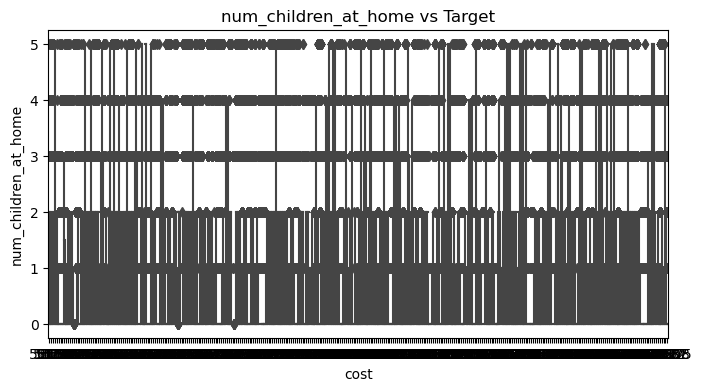

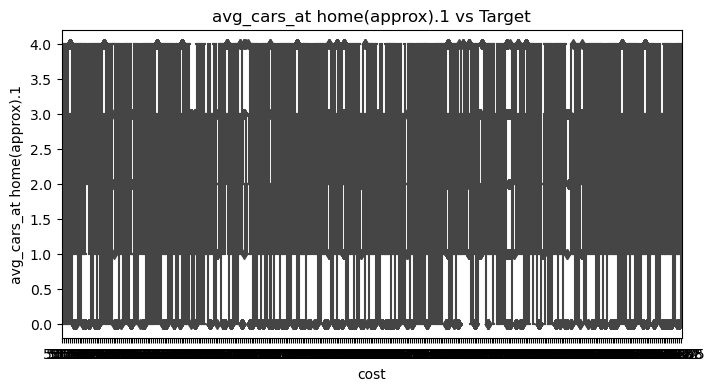

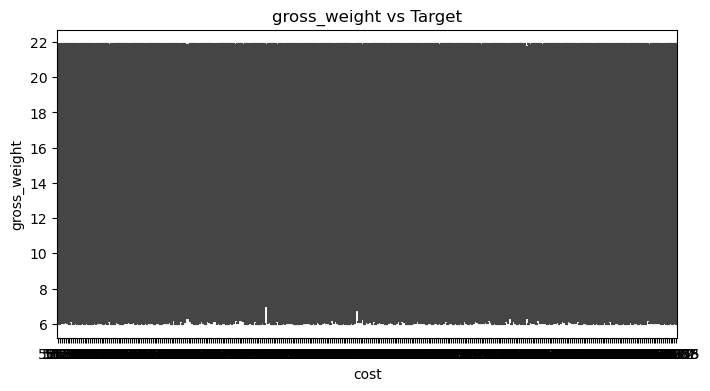

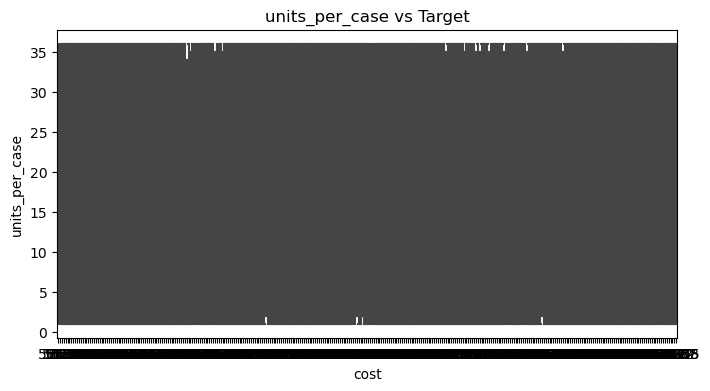

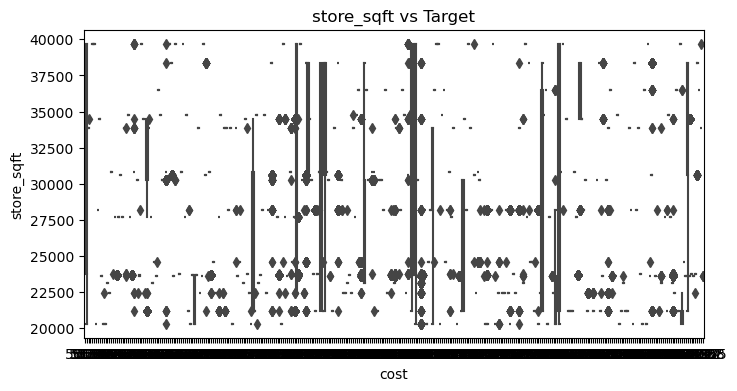

In [ ]:
for col in numerical_cols:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=train["cost"], y=train[col])
    plt.title(f"{col} vs Target")
    plt.show()

### Relationship between Binary variables and Target

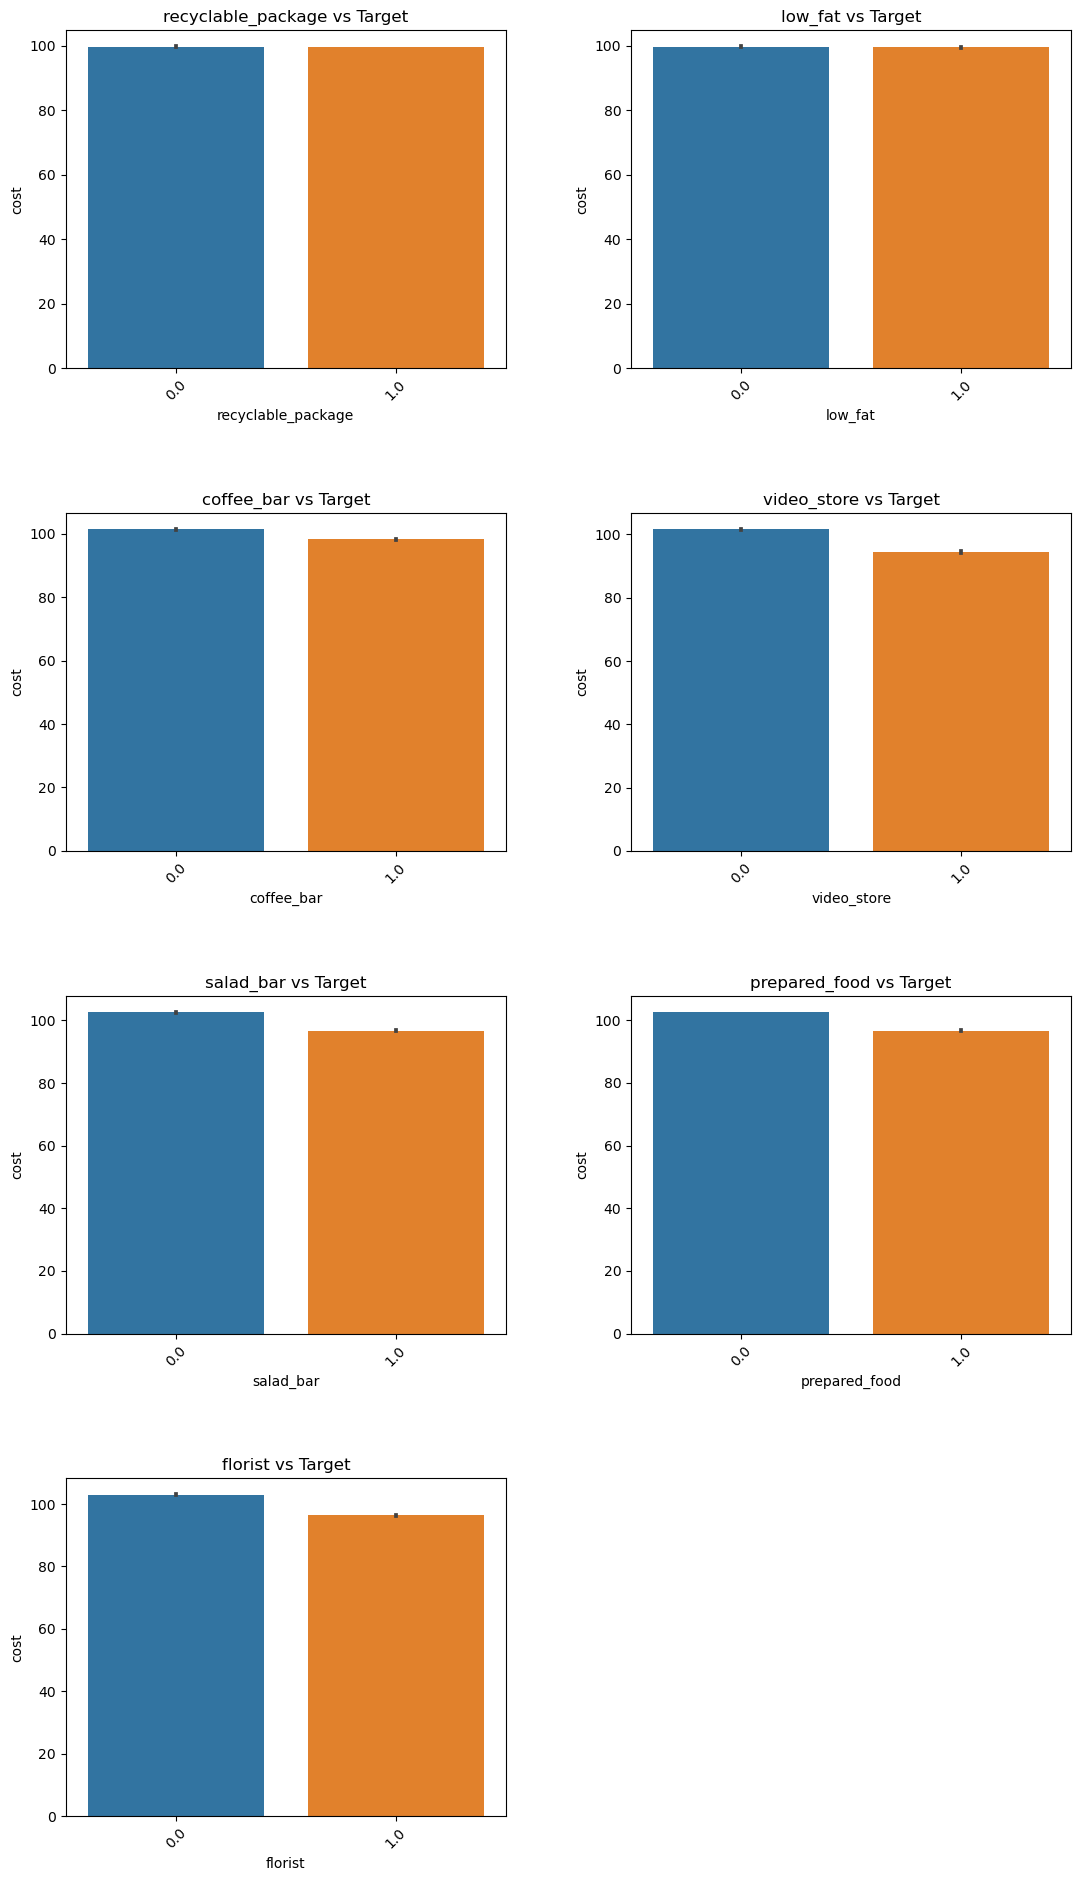

In [ ]:
# for col in binary_cols:
#     plt.figure(figsize=(4, 2))
#     sns.barplot(x=train[col], y=train["cost"])
#     plt.xticks(rotation=45)
#     plt.title(f"{col} vs Target")
#     plt.show()

num_cols = len(binary_cols)
nrows = math.ceil(num_cols / ncols)
# Create subplots
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 5 * nrows))

# Flatten axes for easy indexing
if num_cols == 1:
    axes = [axes]  # Convert to list if only one subplot
else:
    axes = axes.flatten()

# Loop through binary columns and create bar plots
for i, col in enumerate(binary_cols):
    sns.barplot(x=train[col], y=train["cost"], ax=axes[i])
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45)
    axes[i].set_title(f"{col} vs Target")

# Hide any unused subplots if num_cols is odd
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout(pad=5)  # Adjust layout for spacing
plt.show()


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno